# Download Dataset and install librarie



In [5]:
!wget https://www.cse.wustl.edu/~jain/ehms/ftp/wustl-ehms-2020_with_attacks_categories.csv

--2025-01-28 17:03:29--  https://www.cse.wustl.edu/~jain/ehms/ftp/wustl-ehms-2020_with_attacks_categories.csv
Resolving www.cse.wustl.edu (www.cse.wustl.edu)... 128.252.167.136
Connecting to www.cse.wustl.edu (www.cse.wustl.edu)|128.252.167.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3946888 (3.8M) [text/csv]
Saving to: ‘wustl-ehms-2020_with_attacks_categories.csv’

wustl-ehms-2020_wit 100%[===================>]   3.76M  7.43MB/s    in 0.5s    

2025-01-28 17:03:30 (7.43 MB/s) - ‘wustl-ehms-2020_with_attacks_categories.csv’ saved [3946888/3946888]



In [6]:
!pip install xgboost numpy shap

In [7]:
!pip install --upgrade scikit-learn==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


# Load WUSTL-EHMS-2020 Dataset

In [1]:
import pandas as pd

df = pd.read_csv('wustl-ehms-2020_with_attacks_categories.csv')

# Preprocessing the Dataset

In [2]:

# Change "normal" to "Benign" in the 'Attack Category' column
df['Attack Category'] = df['Attack Category'].replace('normal', 'Benign')

col_irrelevantes = ['SrcMac','Dir', 'Label']
col_enderecos = ['Flgs', 'DstMac', 'SrcMac', 'SrcAddr', 'DstAddr', 'Sport']
col_biomedic = ['Temp', 'SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST']

df = df.drop(columns=col_irrelevantes)

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder_AttackCategory = LabelEncoder()
df['Attack Category'] = label_encoder_AttackCategory.fit_transform(df['Attack Category'])

label_encoder_Flgs = LabelEncoder()
df['Flgs'] = label_encoder_Flgs.fit_transform(df['Flgs'])

label_encoder_DstMac = LabelEncoder()
df['DstMac'] = label_encoder_DstMac.fit_transform(df['DstMac'])

#label_encoder_SrcMac = LabelEncoder()
#df['SrcMac'] = label_encoder_SrcMac.fit_transform(df['SrcMac'])

label_encoder_SrcAddr = LabelEncoder()
df['SrcAddr'] = label_encoder_SrcAddr.fit_transform(df['SrcAddr'])

label_encoder_DstAddr = LabelEncoder()
df['DstAddr'] = label_encoder_DstAddr.fit_transform(df['DstAddr'])

label_encoder_Sport = LabelEncoder()
df['Sport'] = label_encoder_Sport.fit_transform(df['Sport'])

df= df.drop(index=10633)
df= df.drop(index=7923)
df= df.drop(index=8412)

# Split, Train and Normalize the Dataset

In [4]:
X = df.drop(columns=['Attack Category'])
y = df['Attack Category']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trainN = scaler.fit_transform(X_train)
X_testN = scaler.transform(X_test)

X_trainN = pd.DataFrame(X_trainN, columns = X_train.columns)
X_testN = pd.DataFrame(X_testN, columns = X_test.columns)

import xgboost as xgb
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_trainN, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Generate Classification Report with Packet num and others

In [5]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_testN)
class_names = ['Benign', 'Data Alteration', 'Spoofing']
print(classification_report(y_test, y_pred, target_names=class_names))


                 precision    recall  f1-score   support

         Benign       0.98      1.00      0.99      2827
Data Alteration       1.00      1.00      1.00       196
       Spoofing       0.94      0.81      0.87       240

       accuracy                           0.98      3263
      macro avg       0.97      0.93      0.95      3263
   weighted avg       0.98      0.98      0.98      3263



# Generate SHAP values and create Plots

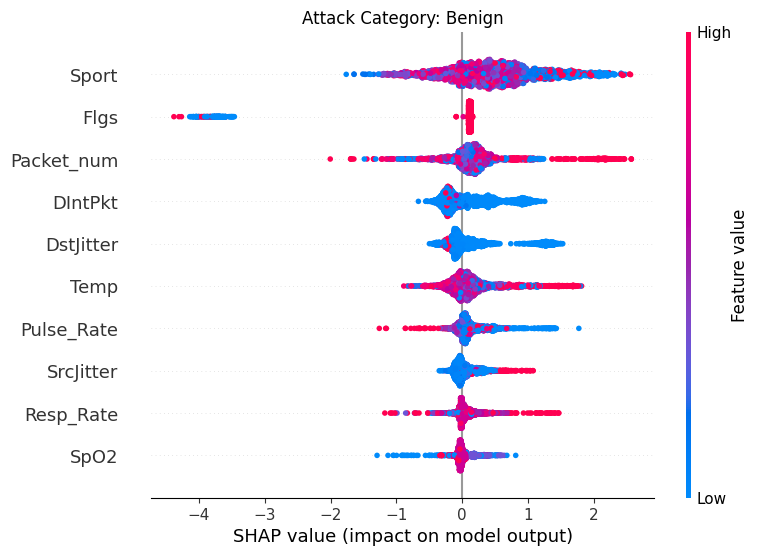

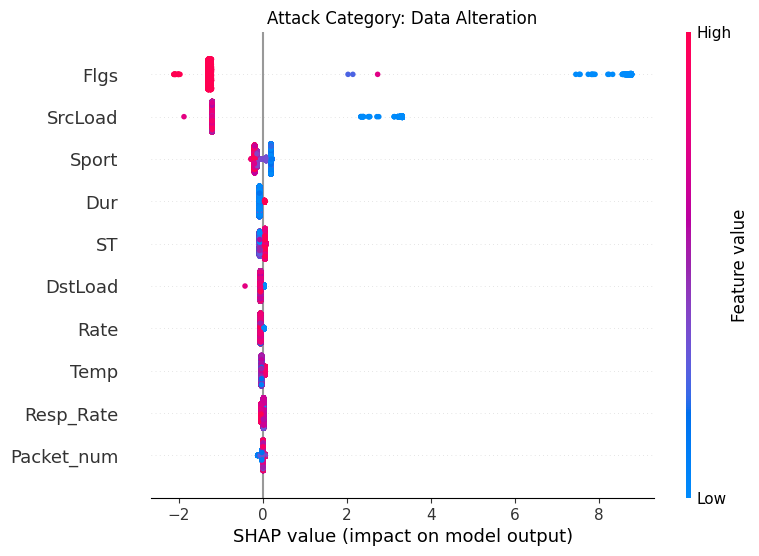

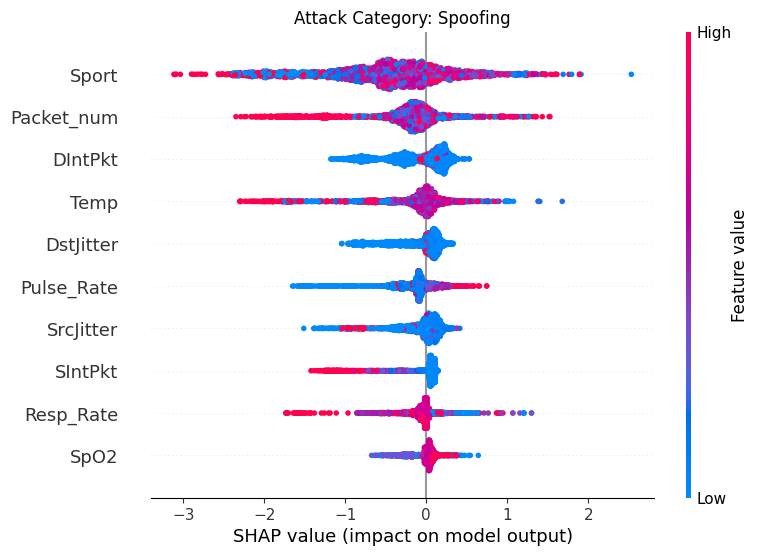

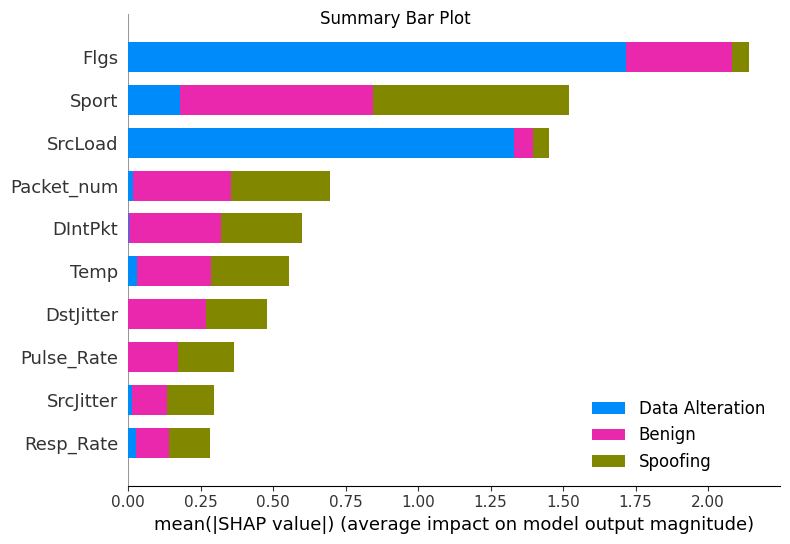

In [6]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_testN)

import matplotlib.pyplot as plt
shap.summary_plot(shap_values[:, :, 0], X_test, show = False, max_display=10)
plt.title("Attack Category: Benign")
plt.show()

shap.summary_plot(shap_values[:, :, 1], X_test, show = False, max_display=10)
plt.title("Attack Category: Data Alteration")
plt.show()

shap.summary_plot(shap_values[:, :, 2], X_test, show = False, max_display=10)
plt.title("Attack Category: Spoofing")
plt.show()

def shap_values_to_list(shap_values, model):
    shap_as_list=[]
    for i in range(len(model.classes_)):
        shap_as_list.append(shap_values[:,:,i])
    return shap_as_list

shap_as_list = shap_values_to_list(shap_values, model)
shap.summary_plot(shap_as_list, X_test, plot_type="bar", class_names=['Benign', 'Data Alteration', 'Spoofing'], show = False, max_display=10)  # Changed from "Normal" to "Benign"
plt.suptitle("Summary Bar Plot")
plt.show()